In [1]:
import os
from glob import glob
import logging
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bids import BIDSLayout
import nibabel as nib
from nistats.design_matrix import make_first_level_design_matrix, make_second_level_design_matrix
from nistats.design_matrix import check_design_matrix
from nistats.reporting import plot_design_matrix, plot_contrast_matrix
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.model import TContrastResults
from nilearn import surface
from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_epi, plot_img, show

<ipython-input-1-618b5c292ed7>:12: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.design_matrix import make_first_level_design_matrix, make_second_level_design_matrix
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import logging
#DEBUG: Detailed information, typically of interest only when diagnosing problems.

#INFOR: Confirmation that things are working as expected.

#WARNING: An indication that something unexpected happened, or indicative of some problem in the near future ( e.g 'disk space low'). The software is still working as expected.

#ERROR: Due to a more serious problem, the software has not been able to perform some function

#CRITICAL: A serious error, indicating that the program itself may be unable to continue running.

#The default of logging is WARNING so it will capture everything at or above warning level and ignore DEBUG and INFO

logging.basicConfig(filename='test.log', level=logging.DEBUG,
                   format='%(asctime)s:%(levelname)s:%(message)s')


def add(x, y):
    return x + y
def subtract(x, y):
    return x - y
def multiply(x, y):
    return x * y
def divide(x, y):
    return x / y



num_1 = 20
num_2 = 10

add_result =  add(num_1,num_2)
logging.debug('Add: {} + {} = {}'.format(num_1, num_2, add_result))
sub_result = subtract(num_1, num_2)
logging.debug('Sub: {} + {} = {}'.format(num_1, num_2, sub_result))
mul_result = multiply(num_1, num_2)
logging.debug('Mul: {} + {} = {}'.format(num_1, num_2, mul_result))
div_result = divide(num_1,num_2)
logging.debug('Div: {} + {} = {}'.format(num_1, num_2, div_result))

ZeroDivisionError: division by zero

In [ ]:
import logging
logging.basicConfig(filename='employee.log', level=logging.INFO,
                   format='%(asctime)s:%(levelname)s:%(message)s')

class Employee:
    """A sample Employee class"""

    def __init__(self, first, last):
        self.first = first
        self.last = last
        
        logging.info('Created Employee: {} - {}'.format(self.fullname, self.email))
        
    @property
    def email(self):
        return '{}.{}@email.com'.format(self.first, self.last)
    
    @property
    def fullname(self):
        return '{} {}'.format(self.first, self.last)
    
emp_1 = Employee('John', 'Smith')
emp_2 = Employee('Corey', 'Schafer')
emp_3 = Employee('Thomas', 'Tan')

In [17]:
%matplotlib inline

In [8]:
def format_events(event_file):
    """
    Argument:
        event_file Full path to events.tsv file
    
    Output:
        event_df Newly formatted events dataframe
    """
    #Read in tsv file
    event_df = pd.read_csv(event_file,delimiter='\t')
    
    #Filter out the one and threeback block from event_df 
    event= event_df[['onset','duration','trial_type']]
    block_type = event[event['trial_type'].str.match("oneback block|threeback block")].copy()
    block_type['trial_type'].replace(" ","_",regex=True,inplace=True)
    
    #Extract hit, miss, and false alarm from dataframe
    mask_hit = (event_df['correct_response'] == 1) & (event_df['participant_response'] == 1)
    mask_miss = (event_df['correct_response'] == 1) & (event_df['participant_response'] == 0)
    mask_false = (event_df['correct_response'] == 0) & (event_df['participant_response'] == 1)
    event_df.loc[mask_hit,"trial_type"] =  event_df['trial_type'].astype(str) + "_hit"
    #event_df.loc[mask_miss,"trial_type"] =  event_df['trial_type'].astype(str) + "_miss"
    event_df.loc[mask_false,"trial_type"] =  event_df['trial_type'].astype(str) + "_false"
    event_df = event_df[['trial_type','duration','onset']]
    events = event_df[event_df['trial_type'].str.endswith(("hit", "false"))]

    #Merge the timing of oneback and threeback together
    df_combined = pd.concat([block_type,events])
    df_combined = df_combined.reset_index(drop=True)
    
    return df_combined


In [9]:
pd.set_option('display.max_row',250)
#Read in tsv file
event_file = '/scratch/ttan/NEUR/rTMS-fMRI/ePRIME/NBACK/completed/NEUR_CMH_HCT203_01_01_NBack.tsv'
tmp=format_events(event_file)
tmp

,onset,duration,trial_type
0,7.000,60,oneback_block
1,71.008,60,threeback_block
2,165.491,60,oneback_block
3,229.399,60,threeback_block
4,323.514,60,oneback_block
5,387.472,60,threeback_block
6,482.690,60,oneback_block
7,547.501,60,threeback_block
8,642.117,60,oneback_block
9,706.108,60,threeback_block


In [10]:
fmri_img = '/scratch/ttan/NEUR/rTMS-fMRI/archive-deri/pipelines/ciftify/sub-CMHHCT203/MNINonLinear/Results/ses-01_task-nbk_run-1_desc-preproc/ses-01_task-nbk_run-1_desc-preproc.nii.gz'
#func_img_avg = mean_img(fmri_img)
#func_img_avg

In [20]:
# mask_hit = (event_df['correct_response'] == 1) & (event_df['participant_response'] == 1)
# mask_miss = (event_df['correct_response'] == 1) & (event_df['participant_response'] == 0)
# mask_false = (event_df['correct_response'] == 0) & (event_df['participant_response'] == 1)
# event_df.loc[mask_hit,"trial_type"] =  event_df['trial_type'].astype(str) + "_hit"
# event_df.loc[mask_miss,"trial_type"] =  event_df['trial_type'].astype(str) + "_miss"
# event_df.loc[mask_false,"trial_type"] =  event_df['trial_type'].astype(str) + "_false"
# event_df = event_df[['trial_type','duration','onset']]

In [21]:
# ending_strings = ("miss", "hit", "false")
# events = event_df[event_df['trial_type'].str.endswith(("miss", "hit", "false"))]
# # print(events)

In [22]:
# 

In [11]:
def extract_confounds(confound_path):
    """
    Arguments:
        confound_path    Full path to confounds.tsv
        confound_vars    List of confound variables to extract
        tr_drop
    
    Outputs:
        confound_df
    """
    
    # Load in data using pandas and extract the relevant columns
    confound_df = pd.read_csv(confound_path, delimiter='\t')
    confound_vars = [col for col in confound_df.columns if col.startswith(("white_matter",
                                                                          "csf",
                                                                          "global_signal",
                                                                          "trans","rot"))]
    confound_df = confound_df[confound_vars]

    # During the initial stages of a functional scan there is a strong signal decay artifact
    # The first few TRs are very high intensity signals that don't reflect the rest of the scan
    # so they are dropped
    tr_drop = 4
    confound_df = confound_df.loc[tr_drop:].reset_index(drop=True)
    
    #demean all the confounds
    for col in confound_df.columns:
        confound_df[col] = confound_df[col].sub(confound_df[col].mean())
        
    # Return confound matrix
    return confound_df

In [12]:
confound_file = '/scratch/ttan/NEUR/rTMS-fMRI/archive-deri/pipelines/fmriprep/sub-CMHHCT203/ses-01/func/sub-CMHHCT203_ses-01_task-nbk_run-1_desc-confounds_regressors.tsv'

In [13]:
confound_df = extract_confounds(confound_file)
confound_df.columns
confound_df

,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_x_power2,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2
0,-17.620750,-15.970446,-38.192023,-117589.763324,-3.118193,3.390716,-34.417530,-25052.639927,-4.246878,-11.562240,...,-0.000039,-3.259465e-07,-0.000158,-0.000177,-1.525394e-06,-1.284757e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
1,-13.206131,4.377638,-272.578506,-88286.285121,4.908705,8.044519,18.635789,39330.798382,3.378602,7.625248,...,-0.000039,-2.941184e-07,-0.000673,-0.000509,-6.161930e-07,1.034304e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
2,-15.870461,-2.701309,-284.968711,-105976.307559,1.169309,-3.721774,-31.812212,9321.215626,4.282630,0.903796,...,-0.000039,-4.231567e-07,-0.000546,0.000133,-8.898064e-07,-1.457638e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
3,-10.961223,4.872257,-267.966752,-73370.021585,0.711432,-0.440256,-45.585640,5648.557694,2.942440,-1.340421,...,-0.000039,-4.842809e-08,-0.000556,-0.000004,-8.692008e-07,-1.618107e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
4,-26.312556,-15.388313,-56.403943,-175170.563723,-5.417776,-6.111586,-8.228108,-43473.761581,0.526456,-2.416216,...,-0.000039,-3.239412e-07,-0.000572,-0.000010,-8.368492e-07,-1.616669e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2.458957,14.255104,-87.803705,16010.431305,-3.621473,4.592932,-24.861827,-29085.138905,13.928819,13.588523,...,0.000064,-8.943092e-08,-0.002736,-0.000464,8.342785e-06,5.894932e-08,0.002260,-0.000477,0.000013,1.416931e-07
412,32.386957,29.891020,603.617852,216632.814542,0.492882,4.131977,-28.867376,3895.705775,17.707433,3.778382,...,0.000047,3.238233e-07,-0.001947,0.000794,3.913255e-06,4.598980e-07,0.002260,-0.000007,0.000013,-7.884983e-08
413,26.344570,-6.079367,-255.556917,175983.338978,-4.686711,-5.161971,-18.967108,-37618.615934,12.310354,-5.397310,...,0.000064,2.911726e-07,-0.002384,-0.000431,6.213138e-06,2.886368e-08,0.002260,-0.000007,0.000013,-7.884983e-08
414,19.025120,-7.356430,-238.493011,126840.369054,-10.620263,-5.915930,-10.588259,-85109.957774,10.437125,-1.873461,...,0.000047,3.632576e-07,-0.002273,0.000117,5.594310e-06,-1.496652e-07,0.002601,0.000333,0.000016,3.706319e-08


In [14]:
confound_file = '/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT203/sub-CMHHCT203_ses-01_task-nbk_run-1_desc-confounds_regressors.tsv'

In [16]:
confound_df = extract_confounds(confound_file)
confound_df

,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_x_power2,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2
0,-17.620750,-15.970446,-38.192023,-117589.763324,-3.118193,3.390716,-34.417530,-25052.639927,-4.246878,-11.562240,...,-0.000039,-3.259465e-07,-0.000158,-0.000177,-1.525394e-06,-1.284757e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
1,-13.206131,4.377638,-272.578506,-88286.285121,4.908705,8.044519,18.635789,39330.798382,3.378602,7.625248,...,-0.000039,-2.941184e-07,-0.000673,-0.000509,-6.161930e-07,1.034304e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
2,-15.870461,-2.701309,-284.968711,-105976.307559,1.169309,-3.721774,-31.812212,9321.215626,4.282630,0.903796,...,-0.000039,-4.231567e-07,-0.000546,0.000133,-8.898064e-07,-1.457638e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
3,-10.961223,4.872257,-267.966752,-73370.021585,0.711432,-0.440256,-45.585640,5648.557694,2.942440,-1.340421,...,-0.000039,-4.842809e-08,-0.000556,-0.000004,-8.692008e-07,-1.618107e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
4,-26.312556,-15.388313,-56.403943,-175170.563723,-5.417776,-6.111586,-8.228108,-43473.761581,0.526456,-2.416216,...,-0.000039,-3.239412e-07,-0.000572,-0.000010,-8.368492e-07,-1.616669e-07,-0.000416,-0.000007,-0.000003,-7.884983e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2.458957,14.255104,-87.803705,16010.431305,-3.621473,4.592932,-24.861827,-29085.138905,13.928819,13.588523,...,0.000064,-8.943092e-08,-0.002736,-0.000464,8.342785e-06,5.894932e-08,0.002260,-0.000477,0.000013,1.416931e-07
412,32.386957,29.891020,603.617852,216632.814542,0.492882,4.131977,-28.867376,3895.705775,17.707433,3.778382,...,0.000047,3.238233e-07,-0.001947,0.000794,3.913255e-06,4.598980e-07,0.002260,-0.000007,0.000013,-7.884983e-08
413,26.344570,-6.079367,-255.556917,175983.338978,-4.686711,-5.161971,-18.967108,-37618.615934,12.310354,-5.397310,...,0.000064,2.911726e-07,-0.002384,-0.000431,6.213138e-06,2.886368e-08,0.002260,-0.000007,0.000013,-7.884983e-08
414,19.025120,-7.356430,-238.493011,126840.369054,-10.620263,-5.915930,-10.588259,-85109.957774,10.437125,-1.873461,...,0.000047,3.632576e-07,-0.002273,0.000117,5.594310e-06,-1.496652e-07,0.002601,0.000333,0.000016,3.706319e-08


In [17]:
#Define all necessary inputs to create a design matrix
files = os.listdir('/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT203/')
nifti_img = os.path.join('/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT203/', next(f for f in files if f.endswith('nbk_run-1_desc-preproc_Atlas_s6.nii')))
func_img = nib.load(nifti_img)
#func_data = func_img.get_data()
n_scans = func_img.shape[-1]

#Define the time repettion from bid json file 
import os
data_dir='/archive/data/NEUR/data/bids'
json_file = os.path.join(data_dir,'sub-CMHHCT202', 'ses-01/func',
                         'sub-CMHHCT202_ses-01_task-nbk_run-1_bold.json')
import json
with open(json_file, 'r') as f:
    t_r = json.load(f)['RepetitionTime']
    
#t_r=2
frame_times = np.arange(n_scans)*t_r


# design matrix input
drift_model = 'polynomial'
drift_order = 5
hrf_model = 'spm + derivative + dispersion'

# first level model input
noise_model = 'ar1'

In [18]:
print(nifti_img)
print(confound_file)
print(event_file)

/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT203/sub-CMHHCT203_ses-01_task-nbk_run-1_desc-preproc_Atlas_s6.nii
/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT203/sub-CMHHCT203_ses-01_task-nbk_run-1_desc-confounds_regressors.tsv
/scratch/ttan/NEUR/rTMS-fMRI/ePRIME/NBACK/completed/NEUR_CMH_HCT203_01_01_NBack.tsv


In [19]:
global tr
global tr_drop
global drift_model
global drift_order
global hrf_model
global noise_model
global period_cut
global event_df
global confound_df
global frame_times

In [20]:
#Create a design matrix
def get_design_matrix(fmri_img,event_file,confound_file):
    """
    Arguments:
    fmri_img        full path to functional data
    event_file      full path to event type tsv file
    
    Output:
    
    dm              a full design matrix
    """

    
    event_df=format_events(event_file)
    confound_df = extract_confounds(confound_file)
    func_img = nib.load(fmri_img)
    n_scans = func_img.shape[-1]
    tr=2
    frame_times = np.arange(n_scans)*tr
    dm = make_first_level_design_matrix(frame_times,
                                        event_df,drift_model=drift_model,
                                        drift_order=drift_order,
                                        add_regs=confound_df,
                                        add_reg_names=list(confound_df.columns),
                                        hrf_model=hrf_model)
    return dm


In [22]:
pd.set_option('display.max_row',550)
dm = get_design_matrix(nifti_img,event_file,confound_file)
dm.to_csv('/scratch/ttan/NEUR/rTMS-fMRI/Analysis/nistats/first_lvl/sub-CMHHCT203/sub-CMHHCT203_ses-01_task-nbk_dm.tsv')

,oneback_block,oneback_block_derivative,oneback_block_dispersion,oneback_hit,oneback_hit_derivative,oneback_hit_dispersion,threeback_block,threeback_block_derivative,threeback_block_dispersion,threeback_false,...,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000,0.000000,7.987487e-17,0.000000e+00,0.000000,1.130439e-18,0.000000,0.000000,-1.996797e-16,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.500000,0.166265,-0.049639,0.014080,-0.003873,1.0
2,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.497590,0.163861,-0.048204,0.013402,-0.003593,1.0
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.495181,0.161469,-0.046786,0.012738,-0.003323,1.0
6,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.492771,0.159088,-0.045385,0.012088,-0.003062,1.0
8,0.000646,0.002774,8.113783e-03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.490361,0.156719,-0.044001,0.011454,-0.002809,1.0
10,0.098771,0.115617,1.500530e-01,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000484,-7.500507e-05,-3.200011e-06,-7.422990e-08,-0.487952,0.154362,-0.042635,0.010833,-0.002566,1.0
12,0.458067,0.210374,4.513352e-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,6.093493e-05,-2.976056e-06,-7.422990e-08,-0.485542,0.152016,-0.041285,0.010227,-0.002332,1.0
14,0.837180,0.155150,-8.717573e-02,1.057838e-04,0.000399,9.428939e-04,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.483133,0.149682,-0.039953,0.009634,-0.002106,1.0
16,1.056437,0.070811,-9.068378e-02,4.598723e-03,0.003260,8.030240e-04,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.480723,0.147360,-0.038637,0.009055,-0.001888,1.0
18,1.136621,0.016990,-7.528594e-02,8.429496e-03,0.000174,-2.391399e-03,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.478313,0.145049,-0.037338,0.008490,-0.001679,1.0


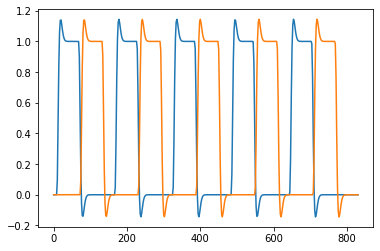

In [20]:
plt.plot(dm[['oneback_block','threeback_block']])

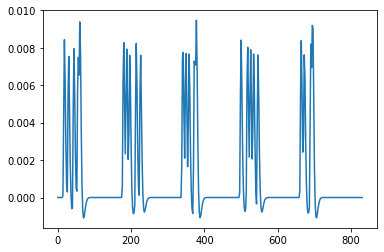

In [31]:
plt.plot(dm[['oneback_hit']])

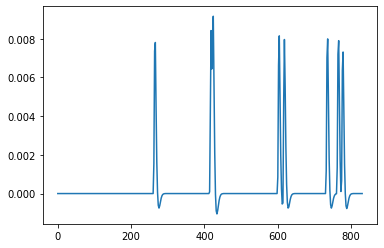

In [32]:
plt.plot(dm[['threeback_hit']])

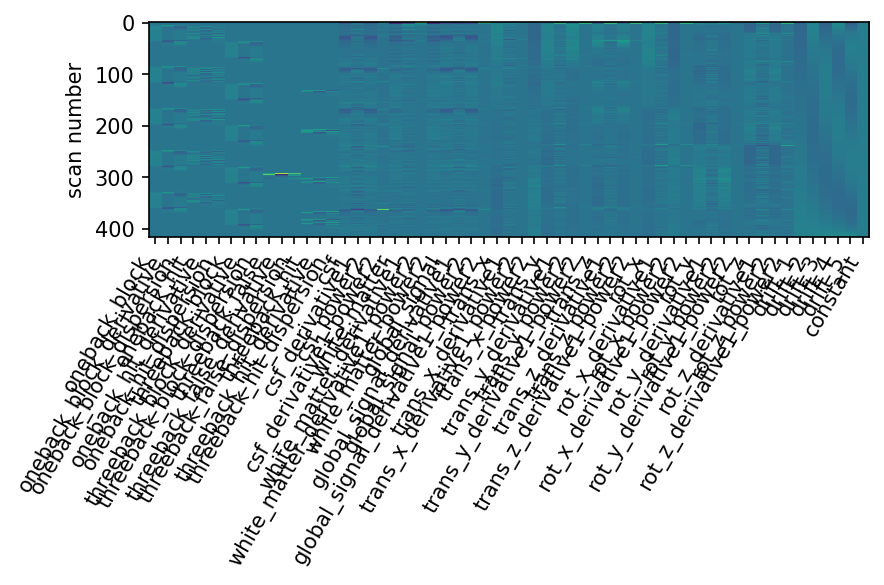

In [40]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.show()
plot_design_matrix(dm)

In [21]:
dm

,oneback_block,oneback_block_derivative,oneback_block_dispersion,oneback_hit,oneback_hit_derivative,oneback_hit_dispersion,threeback_block,threeback_block_derivative,threeback_block_dispersion,threeback_false,...,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000,0.000000,7.987487e-17,0.000000e+00,0.000000,1.130439e-18,0.000000,0.000000,-1.996797e-16,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.500000,0.166265,-0.049639,0.014080,-0.003873,1.0
2,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.497590,0.163861,-0.048204,0.013402,-0.003593,1.0
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.495181,0.161469,-0.046786,0.012738,-0.003323,1.0
6,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.492771,0.159088,-0.045385,0.012088,-0.003062,1.0
8,0.000646,0.002774,8.113783e-03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.490361,0.156719,-0.044001,0.011454,-0.002809,1.0
10,0.098771,0.115617,1.500530e-01,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000484,-7.500507e-05,-3.200011e-06,-7.422990e-08,-0.487952,0.154362,-0.042635,0.010833,-0.002566,1.0
12,0.458067,0.210374,4.513352e-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,6.093493e-05,-2.976056e-06,-7.422990e-08,-0.485542,0.152016,-0.041285,0.010227,-0.002332,1.0
14,0.837180,0.155150,-8.717573e-02,1.057838e-04,0.000399,9.428939e-04,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.483133,0.149682,-0.039953,0.009634,-0.002106,1.0
16,1.056437,0.070811,-9.068378e-02,4.598723e-03,0.003260,8.030240e-04,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.480723,0.147360,-0.038637,0.009055,-0.001888,1.0
18,1.136621,0.016990,-7.528594e-02,8.429496e-03,0.000174,-2.391399e-03,0.000000,0.000000,0.000000e+00,0.000000,...,-0.000416,-7.035072e-06,-2.976056e-06,-7.884983e-08,-0.478313,0.145049,-0.037338,0.008490,-0.001679,1.0


In [23]:
first_lvl_glm = FirstLevelModel(
        t_r=t_r,
        hrf_model=hrf_model,
        drift_model=drift_model,
        drift_order=drift_order,
        noise_model=noise_model,
        standardize=False,
        minimize_memory=False,
        mask_img=False,)

In [24]:
first_lvl_glm

FirstLevelModel(drift_model='polynomial', drift_order=5, fir_delays=[0],
                high_pass=0.01, hrf_model='spm + derivative + dispersion',
                mask_img=False, memory=Memory(location=None), memory_level=1,
                min_onset=-24, minimize_memory=False, n_jobs=1,
                noise_model='ar1', signal_scaling=True, slice_time_ref=0.0,
                smoothing_fwhm=None, standardize=False, subject_label=None,
                t_r=2, target_affine=None, target_shape=None, verbose=0)

In [25]:
first_lvl_glm = first_lvl_glm.fit(nifti_img, design_matrices=dm)

/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nistats/first_level_model.py:73: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


In [33]:
contrast_matrix = np.eye(dm.shape[1])
basic_contrasts = dict(
        [(column, contrast_matrix[i]) for i, column in enumerate(dm.columns)]
    )
basic_contrasts["threeback_minus_oneback"] = (
        basic_contrasts["threeback_block"] - basic_contrasts["oneback_block"]
    )
contrasts_id = [
        "threeback_minus_oneback",
        "oneback_block",
        "threeback_block",
    ]

In [34]:
basic_contrasts

{'oneback_block': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'oneback_block_derivative': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'oneback_block_dispersion': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'oneback_hit': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

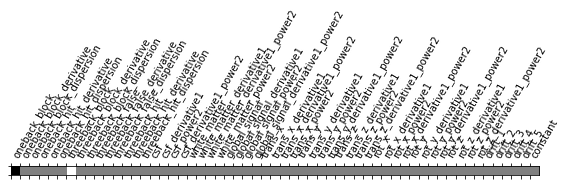

In [77]:
plot_contrast_matrix(basic_contrasts["threeback_minus_oneback"],design_matrix=dm)

In [81]:
t_map = first_lvl_glm.compute_contrast(basic_contrasts["threeback_block"],stat_type="t", output_type="stat")
#t_image_path = path.join(write_dir, '%s_z_map.nii.gz' % contrast_id)
t_map.to_filename('/projects/ttan/SPINS/sub-CMHHCT203_1st_GLM_threeback_tmap.nii.gz')
# for i, val in enumerate(contrasts_id):
#     t_map = first_lvl_glm.compute_contrast(
#             basic_contrasts[contrasts_id[i]], stat_type="t", output_type="stat"
#         )
#     subject_tmap_path = os.path.join(
#             out_dir,
#             "{}_ses-01_task-nbk_{}_t_map.nii.gz".format(
#                 sub_id, contrasts_id[i]
#             ),
#         )


/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=3
  warnings.warn('Too many cuts requested for the data: '


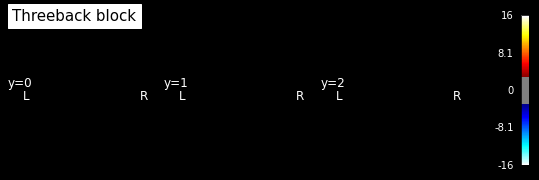

In [85]:
plot_stat_map(t_map,bg_img=func_img_avg, 
              threshold=3.0,
              display_mode='y',  
              black_bg=True,
              title='Threeback block')

In [92]:
from nistats.reporting import make_glm_report

report = make_glm_report(first_lvl_glm,
                        basic_contrasts,
                         bg_img=None
                        )

/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/project

/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/project

/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/project

/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/project

/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:267: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1
  warnings.warn('Too many cuts requested for the data: '
/mnt/tigrlab/project

## Define constants

In [7]:
# # paths
# base_path='/projects/ttan/fMRI_tools'
# input_path='{}/data/preprocessed'.format(base_path)
# out_path='{}/'.format(base_path)

# # scan parameter
# with open('/projects/ttan/fMRI_tools/lists/subs.txt','r') as f:
#     lines = f.read().split('\n')
# subjects = [i for i in lines[:-1]]
# subs_id = [i.replace('sub-CMHHCT', '') for i in lines][:-1]

# task='nback'

In [36]:
# #Generate the design matrix for each session 
# subjects = ['sub-CMHHCT202','sub-CMHHCT203','sub-CMHHCT204','sub-CMHHCT206','subCMHHCT208','sub-CMHHCT209']
# for subject in subjects:
#     sub_id=subject.replace('sub-CMHHCT','')
#     out_dir = os.path.join(out_path, 'test_across3vids',subject)
#         dm = get_design_matrix(fmri_file,event_file,dm_pm)

#         combined_dm_path = os.path.join(out_dir, '{}_ses-01_task-{}_run-{}_dm.tsv'.format(subject,task,run))
# #       print(combined_dm_path)
#         try:
#             os.makedirs(out_dir)
#             print("Directory ", out_dir, " Created ")
#         except FileExistsError:
#             print("Directory ", out_dir, " already exists")
#         print(subject)
#         dm.to_csv(combined_dm_path, sep = '\t')


In [7]:
in_path='/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT202'

In [8]:
files = os.listdir(in_path)

In [9]:
files

['sub-CMHHCT202_ses-01_task-gng_run-1_desc-preproc_Atlas_s6.nii',
 'sub-CMHHCT202_ses-01-task-gng.csv',
 'sub-CMHHCT202_ses-01_task-nbk_run-1_desc-preproc_Atlas_s6.json',
 'sub-CMHHCT202_ses-01_task-gng_run-1_desc-preproc_Atlas_s6.dtseries.nii',
 'sub-CMHHCT202_ses-01_task-gng_run-1_desc-confounds_regressors.tsv',
 'sub-CMHHCT202_ses-01_task-gng_run-1_desc-preproc_Atlas_s6.json',
 'sub-CMHHCT202_ses-01-task-nback.csv',
 'sub-CMHHCT202_ses-01_task-nbk_run-1_desc-preproc_Atlas_s6.nii',
 'sub-CMHHCT202_ses-01_task-nbk_run-1_desc-preproc_Atlas_s6.dtseries.nii',
 'NEUR_CMH_HCT202_01_01_NBack.tsv',
 'sub-CMHHCT202_ses-01_task-nbk_run-1_desc-confounds_regressors.tsv']

In [10]:
nifti_img = os.path.join(
        in_path,
        next(
            f
            for f in files
            if f.endswith("nbk_run-1_desc-preproc_Atlas_s6.nii")
        ),
    )

In [11]:
nifti_img

'/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT202/sub-CMHHCT202_ses-01_task-nbk_run-1_desc-preproc_Atlas_s6.nii'

In [12]:
confound_file = os.path.join(in_path,next(f for f in files if f.endswith("nbk_run-1_desc-confounds_regressors.tsv")),)

In [13]:
confound_file

'/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT202/sub-CMHHCT202_ses-01_task-nbk_run-1_desc-confounds_regressors.tsv'

In [14]:
event_file = os.path.join(in_path, next(f for f in files if f.endswith("NBack.tsv")),)

In [15]:
event_file

'/scratch/ttan/NEUR/rTMS-fMRI/data/preprocessed/sub-CMHHCT202/NEUR_CMH_HCT202_01_01_NBack.tsv'

In [67]:
nifti_img = '/projects/ttan/SPASD/analysis/GLM/sub-CMP0001/2_mm/sub-CMP0001_glm_ea_1stlevel.nii.gz'
func_img = nib.load(nifti_img)

func_img_data = func_img.get_fdata()
func_img.affine

array([[ 1., -0., -0.,  0.],
       [-0.,  1., -0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [73]:
subrick_3 = func_img_data[:,:,:,:,2]

In [74]:
ni_img = nib.Nifti1Image(subrick_3,func_img.affine)
ni_img.affine

array([[ 1., -0., -0.,  0.],
       [-0.,  1., -0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [75]:
nib.save(ni_img,'/projects/ttan/test.nii.gz')

In [28]:
func_img_data[1]

array([[[[ 5.40744591,  1.66295326,  1.15852809, -6.78595924,
          -2.0523355 ,  2.81058502,  5.3295579 ,  2.89498043,
           8.38092899,  0.63422346,  1.56857145,  2.4604466 ,
          -0.05389718, -0.2189015 ,  0.04796055]]],


       [[[ 5.57607985,  2.36823869,  2.06720901,  7.34680939,
           2.78399396,  5.9335022 ,  1.91593838,  1.30397236,
           1.70036781, -0.54658908, -1.69377351,  2.86891651,
           0.09548429,  0.4859001 ,  0.23611797]]],


       [[[ 2.38200331,  0.6137405 ,  0.72049874, -2.90272903,
          -1.47933149,  1.36876142,  1.2343365 ,  1.12982178,
           1.27648008,  0.17936401,  0.74751383,  0.55875731,
          -0.13383693, -0.91596842,  0.83901215]]]])